In [ ]:
library(dplyr)
library(stringr)

data1 = read.table('BCR/Pn3Pilot_HC.tab', header = TRUE, sep = '\t', stringsAsFactors = FALSE)
data2 = read.table('BCR/Pn3Pilot_LC.tab', header = TRUE, sep = '\t', stringsAsFactors = FALSE)


data = rbind(data1, data2)

data$BC = substring(data$SEQUENCE_ID, 1, 12)
data$UMI = substring(data$SEQUENCE_ID, 13, 20)
data$LANE_ID = paste0(data$Sample, data$BC)
head(data)

In [244]:
# trim masked primer sequences
library(stringr)
data$SEQUENCE_TRIM = data$SEQUENCE_INPUT
for (i in 1:dim(data)[1]) {
    vstart = data$V_SEQ_START[i]
    len = str_length(data$SEQUENCE_TRIM[i])
    data$SEQUENCE_TRIM[i] = substring(data$SEQUENCE_TRIM[i], vstart, len) 
    
    jlen = data$J_SEQ_LENGTH[i]
    jstart = data$J_SEQ_START[i]
    len = str_length(data$SEQUENCE_INPUT[i])
    data$SEQUENCE_TRIM[i] = substring(data$SEQUENCE_TRIM[i], 1,jstart - vstart + jlen)
}


In [245]:

data$N_count = str_count(data$SEQUENCE_TRIM, 'N')
data$N_frac = data$N_count / length(data$SEQUENCE_TRIM)
summary(data$N_count)
saveRDS(data, 'BCR/curr_data.RDS')

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   0.00    0.00   25.00   32.46   61.00  139.00    7268 

In [1]:
data = readRDS('BCR/curr_data.RDS')

In [2]:
seurat = readRDS('seurat.RDS')

In [3]:
library(dplyr)
library(ggplot2)


Warning message:
"package 'dplyr' was built under R version 4.1.3"

Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Warning message:
"package 'ggplot2' was built under R version 4.1.3"


In [4]:
library(ggplot2)
matches = data %>% filter(LANE_ID %in% seurat@meta.data$id)#, R1CONSCOUNT > 5)
unmatched =  data %>% filter(Sample != 'Undetermined', !LANE_ID %in% seurat@meta.data$id)#, R1CONSCOUNT > 5, N_count < 3, CDR3_IMGT != '', CDR1_IMGT != '')
dim(unmatched)

[1] 38095    71

In [5]:

library(stringdist)

for (curr_sample in unique(unmatched$Sample)) {
    message(curr_sample)
    sample_bc = seurat$bc[seurat$orig == curr_sample]
    curr_unmatched = unmatched %>% filter(Sample == curr_sample)
    ham_mat = stringdistmatrix(curr_unmatched$BC, sample_bc)
    curr_unmatched$mindist = apply(ham_mat, 1, min)
    curr_unmatched$nearestBC = seurat$bc[apply(ham_mat, 1, which.min)]

    curr_unmatched = curr_unmatched %>% filter(mindist == 1) %>% mutate(LANE_ID = paste0(Sample, BC))
    print(dim(curr_unmatched))
    matches = rbind(curr_unmatched[,colnames(matches)], matches)
    print(dim(matches))

    }

Warning message:
"package 'stringdist' was built under R version 4.1.1"
AB3



[1] 111  73
[1] 44457    71


AC3



[1] 865  73
[1] 45322    71


AB1



[1] 266  73
[1] 45588    71


AB4



[1] 151  73
[1] 45739    71


AC4



[1] 805  73
[1] 46544    71


AB2



[1] 318  73
[1] 46862    71


AC1



[1] 52 73
[1] 46914    71


AC2



[1] 49 73
[1] 46963    71


AC5



[1] 1348   73
[1] 48311    71


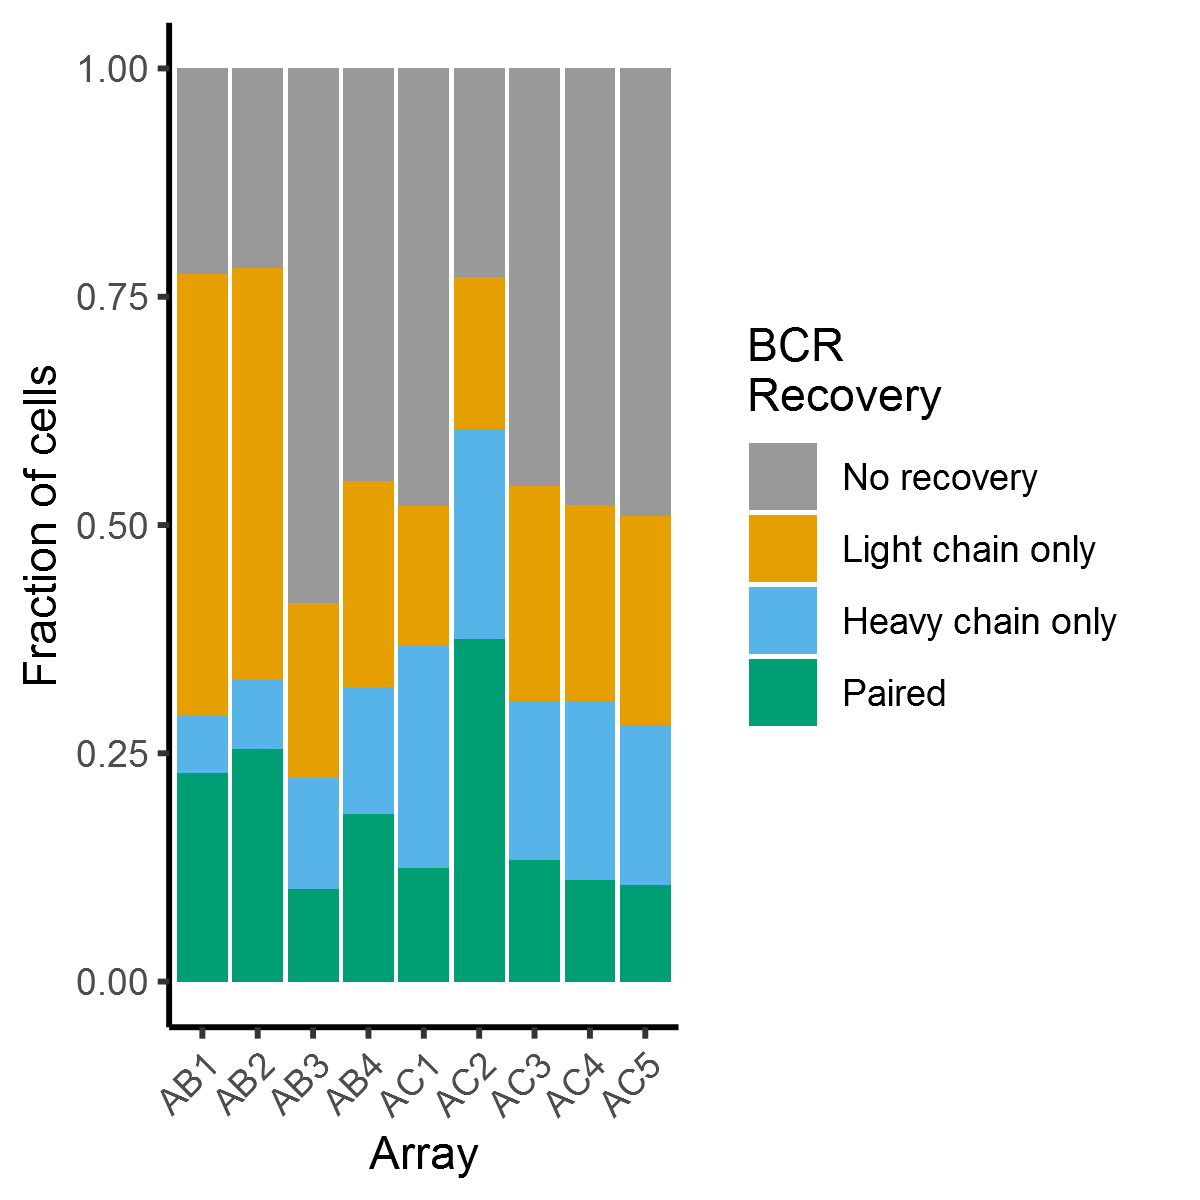

In [6]:
library(ggplot2)
library(stringr)
seurat@meta.data$id = paste0(seurat@meta.data$orig, seurat@meta.data$bc)
hc = matches %>% filter(LOCUS == 'IGH') %>% filter(N_count < 5, FUNCTIONAL, R2CONSCOUNT > 5, CDR3_IMGT != '')
lc = matches %>% filter(LOCUS != 'IGH') %>% filter(N_count < 5
                                                   , FUNCTIONAL, R2CONSCOUNT > 5, CDR3_IMGT != '')

lc$fwr1char = str_count(lc$FWR1_IMGT, fixed('.'))
lc = lc %>% filter(fwr1char != str_length(FWR1_IMGT))

seurat@meta.data$IGH_recovery = as.numeric(seurat@meta.data$id %in% hc$LANE_ID)
seurat@meta.data$IGL_recovery = as.numeric(seurat@meta.data$id %in% lc$LANE_ID) 

seurat@meta.data$letter = substring(seurat@meta.data$orig, 1, 2)

seurat@meta.data$recovery = 2*seurat@meta.data$IGH_recovery + seurat@meta.data$IGL_recovery
cbp1 <- c("#999999", "#E69F00", "#56B4E9", "#009E73",
          "#F0E442", "#0072B2", "#D55E00", "#CC79A7")
options(repr.plot.res = 300, repr.plot.height = 4, repr.plot.width =4 )
ggplot(seurat@meta.data %>% filter(n_genes > 200, !is.na(Monkey)), aes(x = orig, fill = factor(recovery))) + geom_bar(position = 'fill') + scale_fill_manual(labels = c('No recovery','Light chain only', 'Heavy chain only', 'Paired'), values = cbp1) + 
labs(x = 'Array', y = 'Fraction of cells', fill = 'BCR\nRecovery') + theme_classic()+ theme(axis.text.x = element_text(angle = 45, hjust = 1)) 

In [19]:
saveRDS(hc, 'hc.RDS')
saveRDS(lc, 'lc.RDS')

In [7]:
table(seurat$IGH_recovery[seurat$n_genes > 300 ])/length(seurat$IGH_recovery[seurat$n_genes > 100])
table(seurat$IGL_recovery[seurat$n_genes > 300])/length(seurat$IGL_recovery[seurat$n_genes > 100])
sum(seurat$recovery ==3 )/length(seurat$IGL_recovery[seurat$n_genes > 300])


        0         1 
0.7006893 0.2993107 


        0         1 
0.6212055 0.3787945 

[1] 0.1316909

In [9]:
write.table(hc, 'hc.tab', sep= '\t', quote = FALSE, row.names = FALSE)
system('python ../BCRProcess/call_seq_consensus.py hc.tab hc_consensus.tab')

write.table(lc, 'lc.tab', sep= '\t', quote = FALSE, row.names = FALSE)
system('python ../BCRProcess/call_seq_consensus.py lc.tab lc_consensus.tab')


[1] 2

[1] 2

In [10]:
cell_consensus_hc = read.table('hc_consensus.tab', stringsAsFactors = FALSE, sep = '\t', header = TRUE) %>% 
group_by(LANE_ID, Sample, BC) %>% filter(ERRORDIST < 10) %>% mutate(IgM = sum(ISOTYPE == 'IGHM'), IgG = sum(ISOTYPE == 'IGHG1/2'), IgA = sum(ISOTYPE == 'IGHA'), 
                                                                    IgD = sum(ISOTYPE == 'IGHD')) %>% 
                                                                    arrange((ERRORDIST), desc(R2CONSCOUNT)) %>% slice(1) #%>% summarize(n = n())
head(cell_consensus_hc)

cell_consensus_lc = read.table('lc_consensus.tab', stringsAsFactors = FALSE, sep = '\t', header = TRUE) %>% 
group_by(LANE_ID, Sample, BC) %>% arrange((ERRORDIST)) %>% slice(1) #%>% summarize(n = n())
#head(cell_consensus_lc)

SEQUENCE_ID,SEQUENCE_INPUT,FUNCTIONAL,IN_FRAME,STOP,MUTATED_INVARIANT,INDELS,LOCUS,V_CALL,D_CALL,...,N_count,N_frac,CONSENSUS_SEQUENCE,CONSENSUS_SEQCOUNT,ERRORDIST,CONSENSUS_AMBIG,IgM,IgG,IgA,IgD
<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<chr>,<chr>,<chr>,<chr>,...,<int>,<dbl>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
AAAAAACCTGTCACCTGGCG,NNNNNNNNNNNNNNNNNNNNNNNNNTGAAGCCACTGGATTCACCTTCAGTGACTACTACATAAACTGGGTCCGCCAGGCTCCAGGGAAGGGGCCGGAGTGGGTAGGTTGCATTAGAAACAAAGCTAAGGATGGGACAACAGAATACGCCGCGTCTGTGAAAGGCAGATTCACCATCTCAAGAGATGATTCCAAAAGCATTGCCAGCCTGCAAATGAGCAGCCTGAGAACCGAGGACACGGCCGTTTATTACTGTGTTAGAGAGGGACCCCACAGTAAGAACGGGAATATCTACTGGTACTTCGATCTATGGGGCCCTGGCACCCCAATCACCATCTCCGCAGCATCCACCAAGGCTCGTTTCNNNNNNNNNN,True,True,False,NA,False,IGH,IGHV3-116*02,"IGHD4-23*01,IGHD4-41*01",...,0,0,TGAAGCCACT...GGATTCACCTTC............AGTGACTACTACATAAACTGGGTCCGCCAGGCTCCAGGGAAGGGGCCGGAGTGGGTAGGTTGCATTAGAAACAAAGCTAAGGATGGGACAACAGAATACGCCGCGTCTGTGAAA...GGCAGATTCACCATCTCAAGAGATGATTCCAAAAGCATTGCCAGCCTGCAAATGAGCAGCCTGAGAACCGAGGACACGGCCGTTTATTACTGTGTTAGAGAGGGACCCCACAGTAAGAACGGGAATATCTACTGGTACTTCGATCTATGGGGCCCTGGCACCCCAATCACCATCTCCGCAG,1,0,0,1,0,0,1
AAATTGGCCCCGGTAACGCG,NNNNNNNNNNNNNNNNNNNNNNNNNCGCTGTCTCTGGTGGCTCCATCAGCAGTAACTACTGGACCTGGATCCGCCAGCCCCCAGGGAAGGGACTGGAGTGGATTGGACGTATCTCTTATAGTGCTGGGAGCACCGACTACAACCCCTCCCTCAAGAGTCGAGTCACCATTTCAACAGACACGTCCAAGAACCAGTTCTCCCTGAAGCTGAACTCTGTGACCGCCGCGGACACGGCCGTTTATTACTGTGCGAGAGGCTACGGTATCAGTGGATTTGACTACTGGGGCCAGGGAGTCCTGGTCACCGTCTCCTCANNNNNNNNNNN,True,True,False,NA,False,IGH,IGHV4-173*01,IGHD4-29*01,...,0,0,CGCTGTCTCT...GGTGGCTCCATC............AGCAGTAACTACTGGACCTGGATCCGCCAGCCCCCAGGGAAGGGACTGGAGTGGATTGGACGTATCTCTTATAGT......GCTGGGAGCACCGACTACAACCCCTCCCTCAAG...AGTCGAGTCACCATTTCAACAGACACGTCCAAGAACCAGTTCTCCCTGAAGCTGAACTCTGTGACCGCCGCGGACACGGCCGTTTATTACTGTGCGAGAGGCTACGGTATCAGTGGATTTGACTACTGGGGCCAGGGAGTCCTGGTCACCGTCTCCTCA,2,0,0,2,0,0,0
AAGTGCCATTACGATATTGT,NNNNNNNNNNNNNNNNNNNNNNNNNCACTGTTTCTGGAATCCCCATCAGTACTTACTGGTGGAGCTGGATCCGCCAGACCCCAGAGAAGGGACTGGAGTGGATTGGGGAGATCGATGGGAATGGTGGGGGCACCAACTACAACCCCTCCCTCCAGAGTCGAGTCACCTTTTCAAAAGACGCGTCCAAGAATCAGTTCTCCCTGAGGCTGAACTCTGTGACCGCCGCGGACACGGCCGTGTTTTATTGTGCGAGACTATGGGGCAATGCCTACTGGGGCCAGGGAGTCCTGGTCACCGTCTCCTCACNNNNNNNNNN,True,True,False,NA,False,IGH,IGHV4-80*01,"IGHD4-17*01,IGHD4-4*01",...,0,0,..CTGTTTCT...GGAATCCCCATC............AGTACTTACTGGTGGAGCTGGATCCGCCAGACCCCAGAGAAGGGACTGGAGTGGATTGGGGAGATCGATGGGAAT......GGTGGGGGCACCAACTACAACCCCTCCCTCCAG...AGTCGAGTCACCTTTTCAAAAGACGCGTCCAAGAATCAGTTCTCCCTGAGGCTGAACTCTGTGACCGCCGCGGACACGGCCGTGTTTTATTGTGCGAGACTATGGGGCAATGCCTACTGGGGCCAGGGAGTCCTGGTCACCGTCTCCTCA,2,0,0,2,0,0,0
AATCGGTCCTCGTGAAGCTG,NNNNNNNNNNNNNNNNNNNNNNNNNCGCTGTCTCTGGTTACTCCTTCAGCAGTGGTTATTTCTGGGGCTGGATCCGTCAGCCCCCAGGGAAGGGACTGGAGTATATTGGATATATCAGTGGTGAAAGTGGGATTACCTACTACAACCCCTCCCTCAAGAGTCGAGTCACCATTTCAAAAGACACGTCCAAAAACCACTTCTCCCTGAAGCTGTACTCTATAACCGCCGCGGACACGGCCGTCTATTACTGTGCGAGACGGGCTATACTTGTTGGCTTTGACTACTGGGGCCAGGGAGTCCTGGTCACCGTCTCNNNNNNNNNN,True,True,False,NA,False,IGH,IGHV4-99*01,IGHD2-2*01,...,0,0,CGCTGTCTCT...GGTTACTCCTTCAGC.........AGTGGTTATTTCTGGGGCTGGATCCGTCAGCCCCCAGGGAAGGGACTGGAGTATATTGGATATATCAGTGGTGAA......AGTGGGATTACCTACTACAACCCCTCCCTCAAG...AGTCGAGTCACCATTTCAAAAGACACGTCCAANAACCACTTCTCCCTGAAGCTGTACTCTATNACCGCCGCGGACACGGCCGTCTATTACTGTGCGAGACGGGCTATACTTGTTGGCTTTGACTACTGGGGCCAGGGAGTCCTGGTCACCGTCTC,2,2,2,0,0,0,0
AATGACTAGCCGCGTGGTGC,NNNNNNNNNNNNNNNNNNNNTGGGGTGCAGCCTCCGGATTCACCTTCAGTGACTACTACATGTACTGGGTCCGCCAGGCTCCAGGAAAGGGGCTGGAGTGGGTGGGTTTCATTAGAAGCAAAGCTTACGGTGGGACAGCAGAATACGCCGCGTCTGTGAAAGGCAGATTCACCATCTCCAGAGATGATTCCAAAAGCATCGCCTATCTGCAAATGAGCAGCCTGAAAACCGAGGACACGGCCGTGTATTACTGTACTAGGGAGAGGATAGCGGCAGAAATTGACTACTGGGGCCAGGGAGTCCTGGTCACCGTCTCCTCANNNNNNNNNNN,True,True,False,NA,False,IGH,IGHV3-184*02,IGHD6-25*01,...,0,0,TGCAGCCTCC...GGATTCACCTTC............AGTGACTACTACATGTACTGGGTCCGCCAGGCTCCAGGAAAGGGGCTGGAGTGGGTGGGTTTCATTAGAAGCAAAGCTTACGGTGGGACAGCAGAATACGCCGCGTCTGTGAAA...GGCAGATTCACCATCTCCAGAGATGATTCCAAAAGCATCGCCTATCTGCAAATGAGCAGCCTGAAAACCGAGGACACGGCCGTGTATTACTGTA

In [11]:
library(alakazam)
library(stringr)
cell_consensus_hc[,c('FWR1nuc', 'CDR1nuc', 'FWR2nuc', 'CDR2nuc', 'FWR3nuc')]= extractVRegion(cell_consensus_hc$CONSENSUS_SEQUENCE, region = c('fwr1', 'cdr1', 'fwr2', 'cdr2', 'fwr3')) %>% as.data.frame()
cell_consensus_hc$JUNCTION_START = NA
cell_consensus_hc$CDR3nuc = NA
dim(cell_consensus_hc)
cell_consensus_hc = cell_consensus_hc %>% filter(FWR3nuc != '')
dim(cell_consensus_hc)
for (i in 1:nrow(cell_consensus_hc)) {
    cell_consensus_hc$JUNCTION_START[i] = as.numeric(gregexpr(cell_consensus_hc$CONSENSUS_SEQUENCE[i], pattern = cell_consensus_hc$FWR3nuc[i])) + str_length(cell_consensus_hc$FWR3nuc[i])-3
    cell_consensus_hc$CDR3nuc[i] = substring(cell_consensus_hc$CONSENSUS_SEQUENCE[i], cell_consensus_hc$JUNCTION_START[i], cell_consensus_hc$JUNCTION_START[i] + str_length(cell_consensus_hc$JUNCTION[i]) -1)
}

cell_consensus_lc[,c('FWR1nuc', 'CDR1nuc', 'FWR2nuc', 'CDR2nuc', 'FWR3nuc')]= extractVRegion(cell_consensus_lc$CONSENSUS_SEQUENCE, region = c('fwr1', 'cdr1', 'fwr2', 'cdr2', 'fwr3')) %>% as.data.frame()
cell_consensus_lc$JUNCTION_START = NA
cell_consensus_lc$CDR3nuc = NA

for (i in 1:nrow(cell_consensus_lc)) {
    cell_consensus_lc$JUNCTION_START[i] = as.numeric(gregexpr(cell_consensus_lc$CONSENSUS_SEQUENCE[i], pattern = cell_consensus_lc$FWR3nuc[i])) + str_length(cell_consensus_lc$FWR3nuc[i])-3
    #cell_consensus_lc$CDR3nuc[i] = substring(cell_consensus_lc$CONSENSUS_SEQUENCE[i], cell_consensus_lc$JUNCTION_START[i], cell_consensus_lc$JUNCTION_START[i] + str_length(cell_consensus_lc$JUNCTION[i]) -1)
}




Warning message:
"package 'alakazam' was built under R version 4.1.3"
As of v1.0.0 the AIRR Rearrangement schema is now the default file format.
A description of the standard is available at https://docs.airr-community.org.
The legacy Change-O format is supported through arguments to each function
that allow the input column names to be explicitly defined.



[1] 2328   86

[1] 2328   86

In [12]:
library(alakazam)

cell_consensus_hc$CDR1 = translateDNA(cell_consensus_hc$CDR1nuc)
cell_consensus_lc$CDR1 = translateDNA(cell_consensus_lc$CDR1nuc)

cell_consensus_hc$CDR3 = translateDNA(cell_consensus_hc$CDR3nuc)
cell_consensus_lc$CDR3 = translateDNA(cell_consensus_lc$CDR3nuc)

cell_consensus_hc$CDR2 = translateDNA(cell_consensus_hc$CDR2nuc)
cell_consensus_lc$CDR2 = translateDNA(cell_consensus_lc$CDR2nuc)


In [13]:
cell_consensus_hc$Monkey = seurat$Monkey[match(cell_consensus_hc$LANE_ID, seurat$id)]
for (curr in unique(cell_consensus_hc$Monkey)) {
    write.table(cell_consensus_hc %>% filter(Monkey == curr), paste0('C:/Users/dmorgan/IgPhyMl/', curr, '.tab'), quote = FALSE, row.names = FALSE, sep = '\t')
}

In [14]:
files = list.files('C:/Users/dmorgan/IgPhyMl/')
files = files[grep(x = files, pattern = 'germ-pass.tab')][1:8]
files = paste0('C:/Users/dmorgan/IgPhyMl/', files)
for (curr in files) {
   if (curr == files[1]) {
       df = read.table(curr, stringsAsFactors = FALSE, header = TRUE, sep = '\t')
   } 
   else {
       df = rbind(df, read.table(curr, stringsAsFactors = FALSE, header = TRUE, sep = '\t'))
   }    
}

df$CLONE = paste0(df$MONKEY, df$CLONE)
seurat$CLONE = df$CLONE[match(seurat$id, df$LANE_ID)]

In [15]:
library(dplyr)
tab = table(seurat$CLONE)
tab[order(tab, decreasing = TRUE)] %>% head()


 A19N27465 A19N274112 A19N274114  A19N27475 A19N274113 A19N274111 
        19         13         12          7          6          4 

In [16]:
library(shazam)
cell_consensus_hc = observedMutations(df, sequenceColumn = 'CONSENSUS_SEQUENCE', germlineColumn = 'GERMLINE_SEQUENCE_D_MASK', 
                                      frequency = TRUE) %>% mutate(MU_FREQ_TOTAL = mu_freq_seq_r + mu_freq_seq_s) %>% as.data.frame()
cell_consensus_lc = observedMutations(cell_consensus_lc, sequenceColumn = 'CONSENSUS_SEQUENCE', germlineColumn = 'GERMLINE_IMGT', 
                                      frequency = TRUE) %>% mutate(MU_FREQ_TOTAL = mu_freq_seq_r + mu_freq_seq_s)  %>% as.data.frame()

Warning message:
"package 'shazam' was built under R version 4.1.3"
As of v1.0.0 the AIRR Rearrangement schema is now the default file format.
A description of the standard is available at https://docs.airr-community.org.
The legacy Change-O format is supported through arguments to each function
that allow the input column names to be explicitly defined.



In [17]:
                               
seurat@meta.data$ISOTYPE = cell_consensus_hc[seurat@meta.data$id, 'ISOTYPE']                   
seurat@meta.data$ISOTYPEL = cell_consensus_lc[seurat@meta.data$id, 'ISOTYPE']                   


In [18]:
rownames(cell_consensus_hc) = cell_consensus_hc$LANE_ID
rownames(cell_consensus_lc) = cell_consensus_lc$LANE_ID


seurat@meta.data$IGHV = cell_consensus_hc[seurat@meta.data$id, 'V_CALL']
seurat@meta.data$IGHV = sapply(seurat@meta.data$IGHV, function(x) str_split(x, ',')[[1]][1])
seurat@meta.data$IGLV = cell_consensus_lc[seurat@meta.data$id, 'V_CALL']
seurat@meta.data$IGLV = sapply(seurat@meta.data$IGLV, function(x) str_split(x, ',')[[1]][1])
seurat@meta.data$IGHJ = cell_consensus_hc[seurat@meta.data$id, 'J_CALL']
seurat@meta.data$IGHJ = sapply(seurat@meta.data$IGHJ, function(x) str_split(x, ',')[[1]][1])                         
seurat@meta.data$IGH_MU_FREQ = cell_consensus_hc[seurat@meta.data$id, 'MU_FREQ_TOTAL']                   
head(seurat@meta.data)                    
seurat@meta.data$IGH_CDR3 = cell_consensus_hc[seurat@meta.data$id, 'CDR3']                               
seurat@meta.data$IGL_CDR3 = cell_consensus_lc[seurat@meta.data$id, 'CDR3']                               
seurat@meta.data$IGH_CDR3_nuc = cell_consensus_hc[seurat@meta.data$id, 'CDR3_IMGT']                               
seurat@meta.data$IGL_CDR3_nuc = cell_consensus_lc[seurat@meta.data$id, 'CDR3_IMGT']  
seurat@meta.data$IGL_MU_FREQ = cell_consensus_lc[seurat@meta.data$id, 'MU_FREQ_TOTAL']                   
                               
seurat@meta.data$IGH_CDR2 = cell_consensus_hc[seurat@meta.data$id, 'CDR2']                               
seurat@meta.data$IGH_CDR1 = cell_consensus_hc[seurat@meta.data$id, 'CDR1']                               
seurat@meta.data$IGL_CDR1 = cell_consensus_lc[seurat@meta.data$id, 'CDR1']                               
seurat@meta.data$IGL_CDR2 = cell_consensus_lc[seurat@meta.data$id, 'CDR2']                               


                               
seurat@meta.data$ISOTYPE = cell_consensus_hc[seurat@meta.data$id, 'ISOTYPE']                   
seurat@meta.data$ISOTYPEL = cell_consensus_lc[seurat@meta.data$id, 'ISOTYPE']                   



,orig.ident,nCount_RNA,nFeature_RNA,orig,bc,n_genes,n_counts,leiden,id,quality_BC,...,IGH_recovery,IGL_recovery,recovery,CLONE,ISOTYPE,ISOTYPEL,IGHV,IGLV,IGHJ,IGH_MU_FREQ
,<chr>,<dbl>,<int>,<chr>,<chr>,<int>,<dbl>,<int>,<chr>,<chr>,...,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
AB1_0,AB1,4373,1779,AB1,AAAAAACCTGTC,1779,4373,4,AB1AAAAAACCTGTC,True,...,1,1,3,NA,NA,NA,NA,IGKV1S16*01,NA,NA
AB1_1,AB1,1124,660,AB1,AAAAAGAGGCTA,660,1124,7,AB1AAAAAGAGGCTA,True,...,0,0,0,NA,NA,NA,NA,NA,NA,NA
AB1_3,AB1,1016,482,AB1,AAAAGGCCGGGG,482,1016,4,AB1AAAAGGCCGGGG,True,...,0,0,0,NA,NA,NA,NA,NA,NA,NA
AB1_4,AB1,2276,1099,AB1,AAAATTAGAGGA,1099,2276,4,AB1AAAATTAGAGGA,True,...,0,1,1,NA,NA,NA,NA,IGKV2-72*02,NA,NA
AB1_7,AB1,2266,949,AB1,AAACACGGCTAC,949,2266,4,AB1AAACACGGCTAC,True,...,0,1,1,NA,NA,NA,NA,IGLV2-13*02,NA,NA
AB1_14,AB1,4818,1586,AB1,AAATTGGCCCCG,1586,4818,2,AB1AAATTGGCCCCG,True,...,1,1,3,A19N2752,NA,NA,IGHV4-173*01,IGKV2-72*01,IGHJ4*01,0.02205882


In [8]:
saveRDS(df, 'cell_consensus_hc.RDS')


In [39]:
saveRDS(cell_consensus_lc, 'cell_consensus_lc.RDS')


In [11]:
saveRDS(df, 'cell_consensus_hc.RDS')
saveRDS(cell_consensus_lc, 'cell_consensus_lc.RDS')
#saveRDS(seurat@meta.data, 'BCRmeta.RDS')